In [1]:
import pandas as pd 
import numpy as np 
import nfl_data_py as nfl 
from IPython.display import display, HTML

import winsound


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import plot_tree


Read in the plays from the 2021, 2022, and 2023 NFL season. 

In [2]:
plays = nfl.import_pbp_data([2021, 2022, 2023])

2021 done.
2022 done.
2023 done.
Downcasting floats.


Select the fields that I care about for the purposes of this analysis that I can build some simple features off of. Mostly selecting based on information that would be available or readily in the mind of players and coaches at the snap of a any given play. 

In [3]:
#Select the fields that I am interested in using for predicting/feature engineering
fields = ['play_type_nfl', 'play_type'
            , 'week'
              , 'half_seconds_remaining', 'game_seconds_remaining', 'game_half'
              , 'play_id', 'drive', 'game_id'
              , 'posteam', 'defteam'
              , 'yardline_100'
              , 'season_type', 'posteam_type'
              , 'down', 'goal_to_go', 'ydstogo'
              , 'ydsnet', 'yards_gained', 'shotgun', 'no_huddle'
              , 'pass', 'rush', 'first_down', 'touchdown', 'td_team'
              , 'posteam_score', 'defteam_score', 'score_differential'
              , 'game_date', 'home_team', 'away_team'
              , 'total_home_score', 'total_away_score'
              , 'home_timeouts_remaining', 'away_timeouts_remaining'
              , 'posteam_timeouts_remaining', 'defteam_timeouts_remaining'
              , 'penalty_team', 'penalty_yards', 'penalty_type', 'penalty'
              , 'air_yards', 'yards_after_catch', 'incomplete_pass', 'complete_pass', 'passing_yards'
              , 'rush_attempt', 'pass_attempt', 'sack', 'qb_hit'
              , 'pass_touchdown', 'rush_touchdown', 'field_goal_attempt'
              , 'interception', 'fumble_forced', 'fumble_not_forced', 'fumble']

sub_plays = plays.loc[(plays['play_deleted'] == 0) & (plays['play_type'].notna()), fields]

Next I want to create a series of play sequence IDs. I want to know the following: 

* play_seq_game: How many plays have been run in the game (excluding kickoffs, penalties, timeouts)
* play_seq_drive: What number play is this in this drive 
* play_seq_posteam: What number of play is this for the posessing team 
* pass_seq_posteam: How many pass plays have been run so far by the possessing team 
* rush_seq_posteam: How many rush plays 
* shot_seq_posteam: How many plays from shotgun 
* lead_seq_posteam: How many plays has the posessing team had the lead until now 
* fd_seq_posteam: How many first downs as the possessing team gotten 
* sacked_seq_posteam: How many sacks has the possessing team experienced 
* fumble_seq_posteam: How many fumbles has the posessing team experienced 
* int_seq_posteam: How many interceptions has the possessing team experienced

The code section below does a few things. 

1. Name plays that are excluded from counting. These are plays or non-plays that are not really considered part of a drive or occur in-between drives.  
1. Next, create a nested dictionary. It is first a feature name and then a dictionary of conditions that build that feature.  
1. Loop through the nested dictionary and create all features. 

In [4]:
#list the excluded play types from the counters below 
excl_pt = ['kickoff', 'no_play', 'extra_point', 'qb_kneel', 'qb_spike']

#Nested dictionary of counter builders.
seq_config = {
    'play_seq_game': {
        'filters': lambda x: x['play_type'] not in excl_pt
        , 'sort_col': ['game_id', 'game_half', 'game_seconds_remaining']
        , 'sort_orders': [True, True, False]
        , 'grouper': ['game_id']
    }
    , 'play_seq_drive': {
        'filters': lambda x: x['play_type'] not in excl_pt
        ,'sort_col': ['game_id', 'game_half', 'game_seconds_remaining'] 
        ,'sort_orders': [True, True, False] 
        ,'grouper': ['game_id', 'drive']
    } 
    , 'play_seq_posteam': {
        'filters': lambda x: (x['play_type'] not in excl_pt)
        ,'sort_col': ['game_id', 'game_half', 'game_seconds_remaining'] 
        ,'sort_orders': [True, True, False] 
        ,'grouper': ['game_id', 'posteam']
    }
    , 'pass_seq_posteam': {
        'filters': lambda x: (x['play_type'] not in excl_pt) & (x['pass'] == 1)
        ,'sort_col': ['game_id', 'game_half', 'game_seconds_remaining'] 
        ,'sort_orders': [True, True, False] 
        ,'grouper': ['game_id', 'posteam']
    }
    , 'rush_seq_posteam': {
        'filters': lambda x: (x['play_type'] not in excl_pt) & (x['rush'] == 1)
        ,'sort_col': ['game_id', 'game_half', 'game_seconds_remaining'] 
        ,'sort_orders': [True, True, False] 
        ,'grouper': ['game_id', 'posteam']
    }
    , 'shot_seq_posteam': {
        'filters': lambda x: (x['play_type'] not in excl_pt) & (x['shotgun'] == 1)
        ,'sort_col': ['game_id', 'game_half', 'game_seconds_remaining'] 
        ,'sort_orders': [True, True, False] 
        ,'grouper': ['game_id', 'posteam']
    }
    , 'lead_seq_posteam': {
        'filters': lambda x: (x['play_type'] not in excl_pt) & (x['score_differential'] > 0)
        ,'sort_col': ['game_id', 'game_half', 'game_seconds_remaining'] 
        ,'sort_orders': [True, True, False] 
        ,'grouper': ['game_id', 'posteam']
    }
    , 'fd_seq_posteam': {
        'filters': lambda x: (x['play_type'] not in excl_pt) & (x['first_down'] == 1)
        ,'sort_col': ['game_id', 'game_half', 'game_seconds_remaining'] 
        ,'sort_orders': [True, True, False] 
        ,'grouper': ['game_id', 'posteam']
    }
    , 'sacked_seq_posteam': {
        'filters': lambda x: (x['play_type'] not in excl_pt) & (x['sack'] == 1)
        ,'sort_col': ['game_id', 'game_half', 'game_seconds_remaining'] 
        ,'sort_orders': [True, True, False] 
        ,'grouper': ['game_id', 'posteam']
    }
    , 'fumble_seq_posteam': {
        'filters': lambda x: (x['play_type'] not in excl_pt) & (x['fumble'] == 1)
        ,'sort_col': ['game_id', 'game_half', 'game_seconds_remaining'] 
        ,'sort_orders': [True, True, False] 
        ,'grouper': ['game_id', 'posteam']
    }
    , 'int_seq_posteam': {
        'filters': lambda x: (x['play_type'] not in excl_pt) & (x['interception'] == 1)
        ,'sort_col': ['game_id', 'game_half', 'game_seconds_remaining'] 
        ,'sort_orders': [True, True, False] 
        ,'grouper': ['game_id', 'posteam']
    }
}

#Name the columns to join on after creating the features
join_col = ['game_id', 'game_half', 'game_seconds_remaining', 'play_id', 'drive']

#Initiate a list for storing the old keys to make sure I am not duplicating the work. 
old_keys = []

for key, sub in seq_config.items(): 
    #Check the column name being built is already present. If so, skip this loop. 
    if key in sub_plays.columns: 
        print(f'{key} already exists')
        continue
    
    #Pick the plays relevant to the feature being built
    df = sub_plays[sub_plays.apply(sub['filters'], axis = 1)].drop(columns = old_keys)

    #Sort by the required order
    df_sorted = df.sort_values(sub['sort_col']
                               , ascending = sub['sort_orders'])
    
    #Create a counter for the feature
    df_sorted[key] = df_sorted.groupby(sub['grouper']).cumcount() + 1

    #Create a list of the columns to keep and keep them
    keepers = join_col + [key]

    right = df_sorted.loc[:,keepers]

    #Rejoin these features to the plays dataset
    sub_plays = sub_plays.merge(right
                                , on = join_col
                                , how = 'left')
    
    old_keys = old_keys + [key]

Next some of the play counters need to be shifted. For example, it currently adds a counter for a running play if the current play is a run. But it needs to shift that information forward one play. That way the current row is considering counters for all plays that had happened so far in this game, not including the play about to happen. 

In [5]:
seq_fix = ['pass_seq_posteam', 'rush_seq_posteam', 'shot_seq_posteam'
           , 'lead_seq_posteam', 'fd_seq_posteam', 'sacked_seq_posteam'
           , 'fumble_seq_posteam', 'int_seq_posteam']

for col in seq_fix: 
    print(f'{col}_shift')
    sub_plays[f'{col}_shift'] = (
    sub_plays.groupby(['game_id', 'posteam'], group_keys = False)[col]
        .apply(lambda group: group.ffill().fillna(0).shift(1).fillna(0))
        )
    
sub_plays['last_play'] = (
    sub_plays.loc[~sub_plays['play_type'].isin(excl_pt), ['game_id', 'posteam', 'play_type']]
    .groupby(['game_id', 'posteam'])['play_type']
    .shift(1)
)

pass_seq_posteam_shift
rush_seq_posteam_shift
shot_seq_posteam_shift
lead_seq_posteam_shift
fd_seq_posteam_shift
sacked_seq_posteam_shift
fumble_seq_posteam_shift
int_seq_posteam_shift


Next filter down to only active plays, and pull out the target to be predicted. This is 'conversion', effectively if something is a first down or a touchdown. Not considering field goals because they are less fun. 

In [6]:
excl_pt = ['kickoff', 'no_play', 'extra_point']
filt = lambda x: (x['play_type'] not in excl_pt)

print(f'Original PBP length is {len(sub_plays)}')
sub_plays_filt = sub_plays[sub_plays.apply(filt, axis = 1)]
print(f'Included PBP length is {len(sub_plays_filt)}')

sub_plays_filt.loc[:, 'target'] = sub_plays_filt.apply(
    lambda x: 1 if (x['first_down'] == 1) 
              or ((x['touchdown'] == 1) and (x['posteam'] == x['td_team'])) 
              else 0, 
    axis=1
)

y = sub_plays_filt.loc[:, 'target'] 
# x = sub_plays_filt.loc[:, ['game_half', 'last_play'
#                            , 'game_seconds_remaining', 'yardline_100', 'score_differential'


#                            , 'play_seq_game', 'play_seq_drive', 'play_seq_posteam', 'pass_seq_posteam', 'rush_seq_posteam', 'shot_seq_posteam', 'lead_seq_posteam', 'fd_seq_posteam', 'sacked_seq_posteam', 'fumble_seq_posteam', 'int_seq_posteam' 
                           
#                            , 'goal_to_go', 'down', 'ydstogo'
                           
#                            , 'shotgun', 'no_huddle'

#                            , 'posteam_timeouts_remaining', 'defteam_timeouts_remaining'
                           
#                            ,'drive', 'week']]




Original PBP length is 144659
Included PBP length is 118427


C:\Users\chris\AppData\Local\Temp\ipykernel_26172\4160182210.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_plays_filt.loc[:, 'target'] = sub_plays_filt.apply(


No I start with building just a single model just to get an example tree out of. Model fit and parameters irrelevant for this example. 

In [ ]:
#Pull out all features for prediction
x = sub_plays_filt.loc[:, ['shotgun', 'game_half', 'last_play', 'no_huddle'
                           , 'down', 'yardline_100', 'goal_to_go', 'ydstogo'
                           , 'score_differential'
                           , 'play_seq_game', 'play_seq_drive', 'drive'
                           , 'play_seq_posteam'
                           , 'pass_seq_posteam_shift', 'rush_seq_posteam_shift', 'shot_seq_posteam_shift'
                           , 'lead_seq_posteam_shift', 'sacked_seq_posteam_shift', 'fumble_seq_posteam_shift', 'int_seq_posteam_shift' 
                           , 'posteam_timeouts_remaining', 'defteam_timeouts_remaining']]

# Identify categorical and numerical columns
categorical_cols = x.select_dtypes(include=['object']).columns
numerical_cols = x.select_dtypes(include=['number']).columns

print(f'Categorical cols: {categorical_cols}') 
print(f'Numeric cols: {numerical_cols}')

# Preprocessing for categorical and numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols), #Standardize numeric variables with mean 0 and variance 1 
        ('cat', OneHotEncoder(drop='first'), categorical_cols) #One-hot encode categorical variables, meaning an indicator for each possible value
    ]
)

# Define the Random Forest pipeline. First it runs the preprocessor above, then it fits a specified model. 
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42
                                          , n_estimators = 100
                                          , max_depth = 8
                                          , max_features = 'sqrt'
                                          , bootstrap = True))
])

# Split data into train and test sets with 20% test holdout
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Fit the pipeline on the training data
pipeline.fit(x_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(x_test)

# Evaluate the model predictions
print(classification_report(y_test, y_pred))


Categorical cols: Index(['game_half', 'last_play'], dtype='object')
Numeric cols: Index(['shotgun', 'no_huddle', 'down', 'yardline_100', 'goal_to_go', 'ydstogo',
       'score_differential', 'play_seq_game', 'play_seq_drive', 'drive',
       'play_seq_posteam', 'pass_seq_posteam_shift', 'rush_seq_posteam_shift',
       'shot_seq_posteam_shift', 'lead_seq_posteam_shift',
       'sacked_seq_posteam_shift', 'fumble_seq_posteam_shift',
       'int_seq_posteam_shift', 'posteam_timeouts_remaining',
       'defteam_timeouts_remaining'],
      dtype='object')
              precision    recall  f1-score   support

           0       0.77      0.96      0.86     17404
           1       0.66      0.19      0.30      6282

    accuracy                           0.76     23686
   macro avg       0.71      0.58      0.58     23686
weighted avg       0.74      0.76      0.71     23686



Consider the above model output under the below definitions. 
__Precision__: True positives / all observations  

__Recall__: True Positives / all observed positives  

__F1__: 2 * ([Precision * Recall] / [Precision + Recall])

__Accuracy__: True positive + True Negative / all observations (% of correctly identified cases) 

Macro avg: The average of the two values in the above column 
Weighted avg: The average of the two values weighted by support in the columns above 

Below I pull out a single tree from the model above. Originally considered using this in the paper but ultimately just built a more naive example for easier interpretability. 

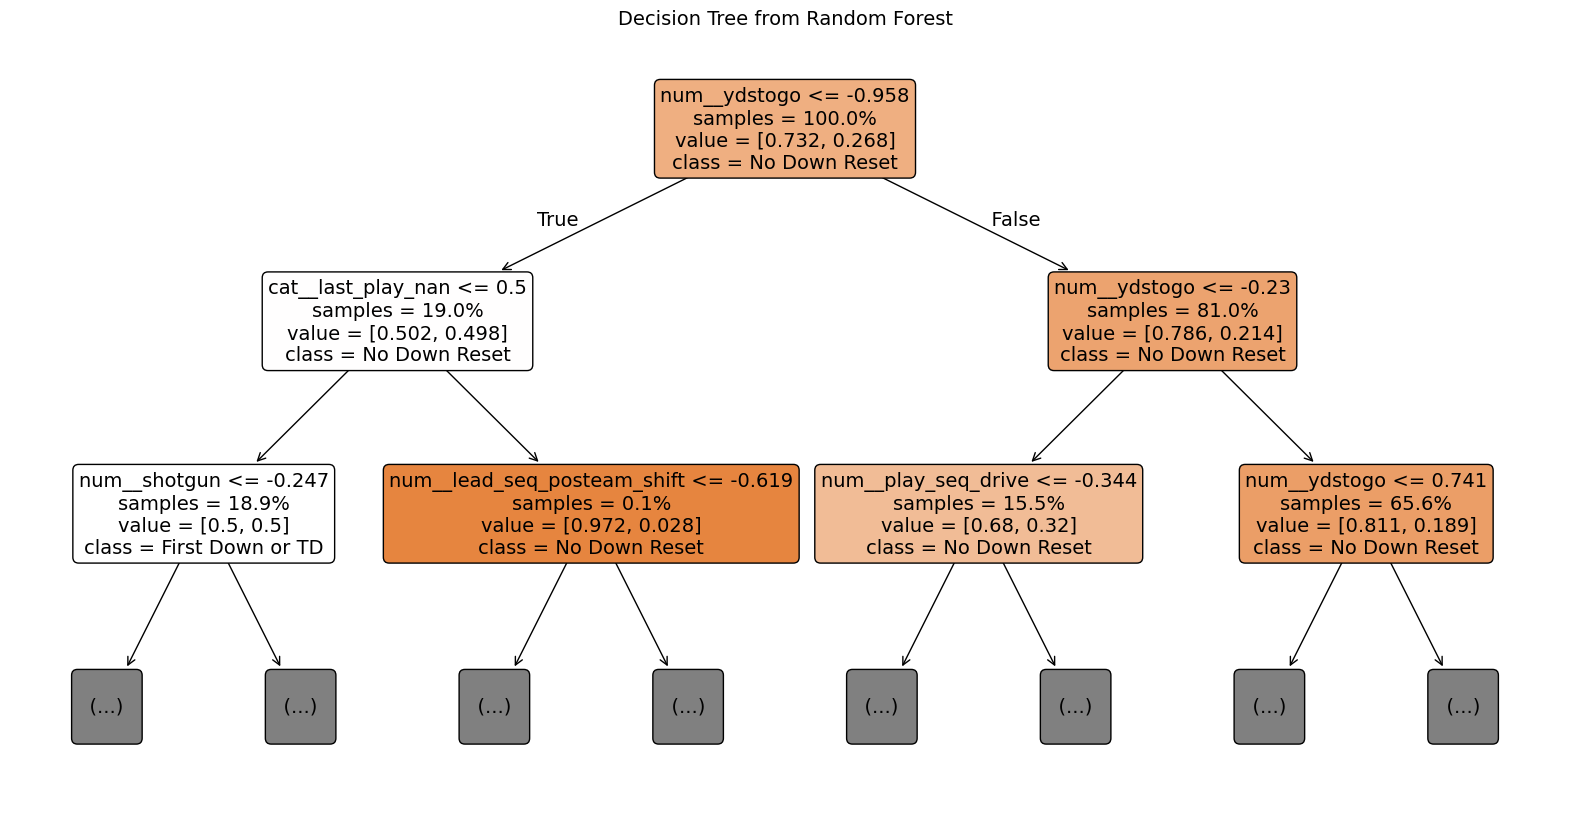

In [ ]:
# Extract a single tree from the trained Random Forest model
rf_model = pipeline.named_steps['classifier']
single_tree = rf_model.estimators_[0]  # Get the first tree

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(single_tree 
          ,impurity = False
          ,max_depth = 2
          ,proportion = True
          ,feature_names=pipeline.named_steps['preprocessor'].get_feature_names_out()
          ,class_names=['No Down Reset', 'First Down or TD']
          ,filled=True, rounded=True, fontsize=14)

plt.title("Decision Tree from Random Forest", fontsize=14)
plt.show()


Below I do a couple rounds of grid searches with cross validation. A grid search takes a set of paramaters, and a list of possible values for each of those parameters, and fits a model for all possible combinations. For each combination here I also do a 5-fold cross validation. This means that the 80% of the data for training in split into 4 pieces, a model is trained, and the remaining 1 piece is used to test. Repeat for all pieces. 

This is a process that I use just to demonstrate how you would go about fitting the best possible model with the data available. Ignore the fact that there are some obviously very important features missing, and imagine this process was being done with all features available. 

In [ ]:
#ID the features to use
x = sub_plays_filt.loc[:, ['shotgun', 'game_half', 'last_play', 'no_huddle'
                           , 'down', 'yardline_100', 'goal_to_go', 'ydstogo'
                           , 'score_differential'
                           , 'play_seq_game', 'play_seq_drive', 'drive'
                           , 'play_seq_posteam'
                           , 'pass_seq_posteam_shift', 'rush_seq_posteam_shift', 'shot_seq_posteam_shift'
                           , 'lead_seq_posteam_shift', 'sacked_seq_posteam_shift', 'fumble_seq_posteam_shift', 'int_seq_posteam_shift' 
                           , 'posteam_timeouts_remaining', 'defteam_timeouts_remaining']]

#Set down as character instead of numeric as it was above. 
x['down'] = x['down'].astype('object')

# Identify categorical and numerical columns
categorical_cols = x.select_dtypes(include=['object']).columns
numerical_cols = x.select_dtypes(include=['number']).columns

print(f'Categorical cols: {categorical_cols}') 
print(f'Numeric cols: {numerical_cols}')

# Preprocessing for categorical and numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)

# Define the Random Forest pipeline. First it runs the preprocessor above, then it fits a specified model. 
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), #Standardize numeric variables with mean 0 and variance 1 
    ('classifier', RandomForestClassifier(random_state=42)) #One-hot encode categorical variables, meaning an indicator for each possible value
])

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Define the parameter grid that we iterate through to find the best model fit from these combinations
param_grid = {
    'classifier__n_estimators': np.array(range(100, 500 + 1, 100)), 
    'classifier__max_depth': np.array(range(20, 30 + 1, 10)),
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__bootstrap': [False, True]
}

# Apply GridSearchCV to the pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=3)
grid_search.fit(x_train, y_train)

# Play a simple ding sound when done
winsound.Beep(2000, 1500)  # Frequency 1000 Hz for 500 milliseconds

Categorical cols: Index(['game_half', 'last_play', 'down'], dtype='object')
Numeric cols: Index(['shotgun', 'no_huddle', 'yardline_100', 'goal_to_go', 'ydstogo',
       'score_differential', 'play_seq_game', 'play_seq_drive', 'drive',
       'play_seq_posteam', 'pass_seq_posteam_shift', 'rush_seq_posteam_shift',
       'shot_seq_posteam_shift', 'lead_seq_posteam_shift',
       'sacked_seq_posteam_shift', 'fumble_seq_posteam_shift',
       'int_seq_posteam_shift', 'posteam_timeouts_remaining',
       'defteam_timeouts_remaining'],
      dtype='object')
Fitting 5 folds for each of 120 candidates, totalling 600 fits


Below prints out the best paramter sets from the given grid search above. Running this grid search on my local computer it took ~35 minutes with 3 seasons of data, and <15 with 1 season. I use the output of this grid search to run another grid search below trying to further improve model specifications. Most likely, the biggest weakness is just not enough good features here. 

The most noteworthy conclusion from the grid search here is that bootstrapping for individual tree creation is not better here. This is because this is a pretty small sample of data. With 80% of the data (originally 118k rows) in training and 80% of that being used in each cross validation you end up with only ~75k observations in each tree. With much larger samples bootstrapping would be better most likely. 

In [10]:
# Print best parameters
best_params = grid_search.best_params_

# Print best parameters
print("Best Parameters:", pd.DataFrame.from_dict(best_params, orient='index', columns=['Value']))

Best Parameters:                                Value
classifier__bootstrap          False
classifier__max_depth             30
classifier__max_features        sqrt
classifier__min_samples_split      5
classifier__n_estimators         200


Below I plot out the results of the grid search. For a simple explanation, the y axis is an overall accuracy measure, the x axis is the number of trees in a given random forest, the colors specify the number of samples minimally required for each node split, and the shape determines the max depth, or the number of times a decision tree can split. Each subplot then is some combination of boostrapping or not, and the two main feature ID approaches. 

Importantly, you'll note that if we look for the dot that corresponds to the printout above that is the dot highest on the x axis. 

c:\Users\chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The markers list has more values (4) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
c:\Users\chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The markers list has more values (4) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
c:\Users\chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The markers list has more values (4) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
c:\Users\chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: The markers list has more values (4) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)


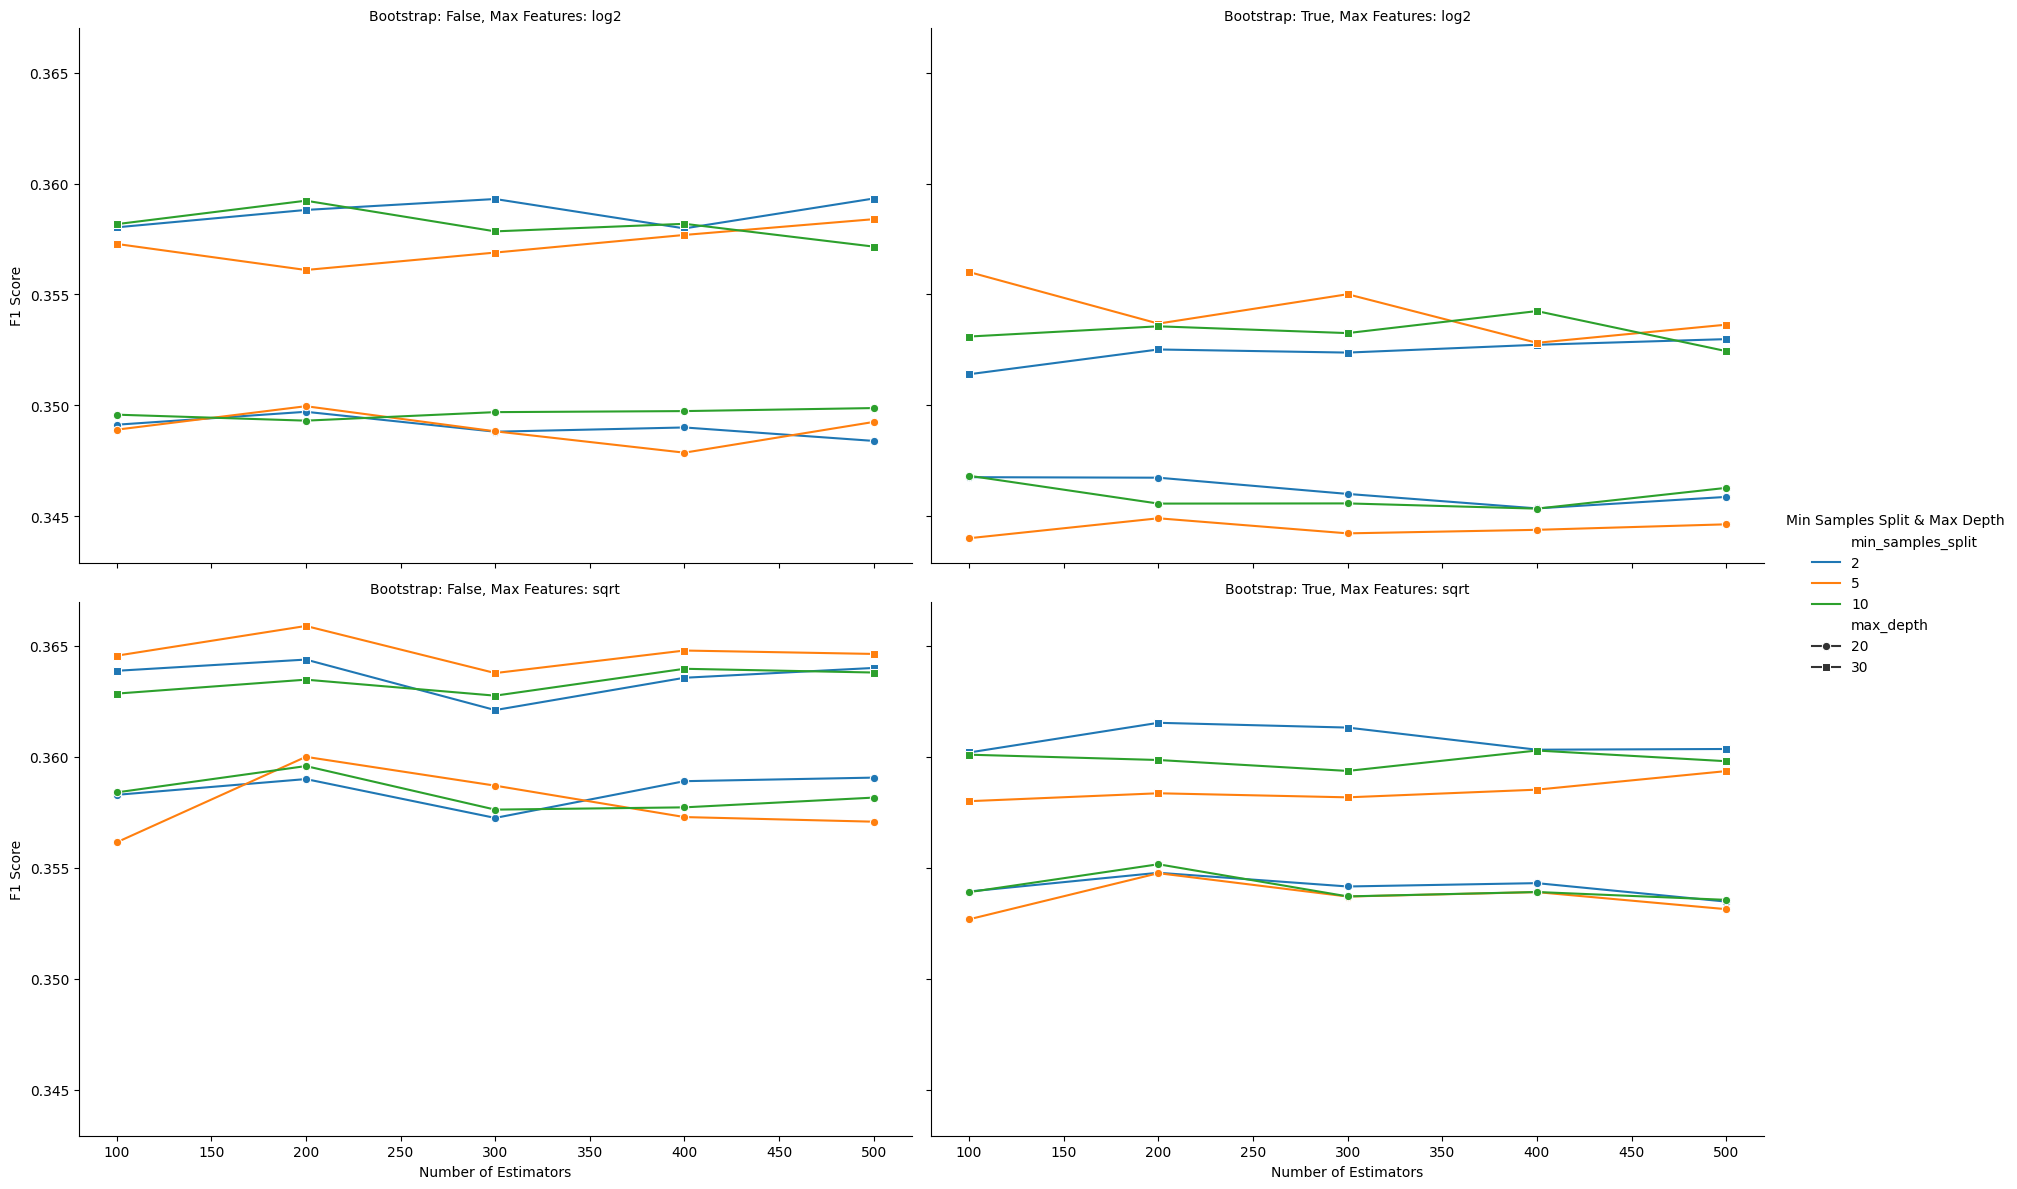

In [ ]:
# Assuming grid_search is your fitted grid search object
results = pd.DataFrame(grid_search.cv_results_)

# Rename columns for easier access
plot_results = results.rename(columns = {
    'param_classifier__bootstrap': 'bootstrap',
    'param_classifier__max_depth': 'max_depth',
    'param_classifier__max_features': 'max_feat',
    'param_classifier__min_samples_split': 'min_samples_split',
    'param_classifier__n_estimators': 'n_estimators',
    'mean_test_score': 'f1'
})

# Convert 'max_depth' to integer, ensure other necessary columns are integers
plot_results['max_depth'] = plot_results['max_depth'].astype(int)
plot_results['n_estimators'] = plot_results['n_estimators'].astype(int)
plot_results['min_samples_split'] = plot_results['min_samples_split'].astype('category')

# Ensure 'max_feat' is treated as a categorical variable for faceting
plot_results['max_feat'] = plot_results['max_feat'].astype('category')

# Ensure 'min_samples_split' is treated as a categorical variable for hue
plot_results['min_samples_split'] = plot_results['min_samples_split'].astype('category')

# Create a FacetGrid based on 'bootstrap' and 'max_feat'
g = sns.FacetGrid(plot_results,
                  col='bootstrap',          # Facet by 'bootstrap'
                  row='max_feat',           # Facet by 'max_feat'
                  height=6,                 # Set plot height
                  aspect=1.5)               # Set aspect ratio

# Map the lineplot, specifying the correct x and y values, and grouping by 'min_samples_split'
g.map(sns.lineplot,
      'n_estimators',           # X-axis: 'n_estimators' 
      'f1',                      # Y-axis: 'f1' (mean test score)
      hue=plot_results['min_samples_split'],   # Grouping by 'min_samples_split'
      style=plot_results['max_depth'],         # Different line styles for 'max_depth'
      markers=['o', 's', '^', 'D'],  # Use markers for different groups
      dashes=False)              # Disable dashes for lines

# Add labels, titles, and legends
g.set_axis_labels("Number of Estimators", "F1 Score")
g.set_titles("Bootstrap: {col_name}, Max Features: {row_name}")
g.add_legend(title="Min Samples Split & Max Depth")

# Show the plot
plt.show()


Using the information above, I want to run a few more models through a grid search to see if anything is better. Now I decide to never boostrap, select 5 as the min sample split, and use the square root as the number of features to sample at each node. Then, I test a bunch of different depth and forest size combinations. 

In [12]:
x = sub_plays_filt.loc[:, ['shotgun', 'game_half', 'last_play', 'no_huddle'
                           , 'down', 'yardline_100', 'goal_to_go', 'ydstogo'
                           , 'score_differential'
                           , 'play_seq_game', 'play_seq_drive', 'drive'
                           , 'play_seq_posteam'
                           , 'pass_seq_posteam_shift', 'rush_seq_posteam_shift', 'shot_seq_posteam_shift'
                           , 'lead_seq_posteam_shift', 'sacked_seq_posteam_shift', 'fumble_seq_posteam_shift', 'int_seq_posteam_shift' 
                           , 'posteam_timeouts_remaining', 'defteam_timeouts_remaining']]

x['down'] = x['down'].astype('object')

# Identify categorical and numerical columns
categorical_cols = x.select_dtypes(include=['object']).columns
numerical_cols = x.select_dtypes(include=['number']).columns

print(f'Categorical cols: {categorical_cols}') 
print(f'Numeric cols: {numerical_cols}')

# Preprocessing for categorical and numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)

# Define the Random Forest pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'classifier__n_estimators': np.array(range(100, 800 + 1, 100)), 
    'classifier__max_depth': np.array(range(20, 60 + 1, 10)),
    'classifier__min_samples_split': [5],
    'classifier__max_features': ['sqrt'],
    'classifier__bootstrap': [False]
}

# Apply GridSearchCV to the pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=3)
grid_search.fit(x_train, y_train)

# Play a simple ding sound when done
winsound.Beep(2000, 1500)  # Frequency 1000 Hz for 500 milliseconds

Categorical cols: Index(['game_half', 'last_play', 'down'], dtype='object')
Numeric cols: Index(['shotgun', 'no_huddle', 'yardline_100', 'goal_to_go', 'ydstogo',
       'score_differential', 'play_seq_game', 'play_seq_drive', 'drive',
       'play_seq_posteam', 'pass_seq_posteam_shift', 'rush_seq_posteam_shift',
       'shot_seq_posteam_shift', 'lead_seq_posteam_shift',
       'sacked_seq_posteam_shift', 'fumble_seq_posteam_shift',
       'int_seq_posteam_shift', 'posteam_timeouts_remaining',
       'defteam_timeouts_remaining'],
      dtype='object')
Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [20]:
# Print best parameters
best_params = grid_search.best_params_

# Print best parameters
print("Best Parameters:", pd.DataFrame.from_dict(best_params, orient='index', columns=['Value']))

Best Parameters:                                Value
classifier__bootstrap          False
classifier__max_depth             40
classifier__max_features        sqrt
classifier__min_samples_split      5
classifier__n_estimators         200


THe best paramters printed out above and the plots below show that 200 is still the best number of estimators, but 40 for a max depth is better. 

c:\Users\chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: 
The markers list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  func(*plot_args, **plot_kwargs)


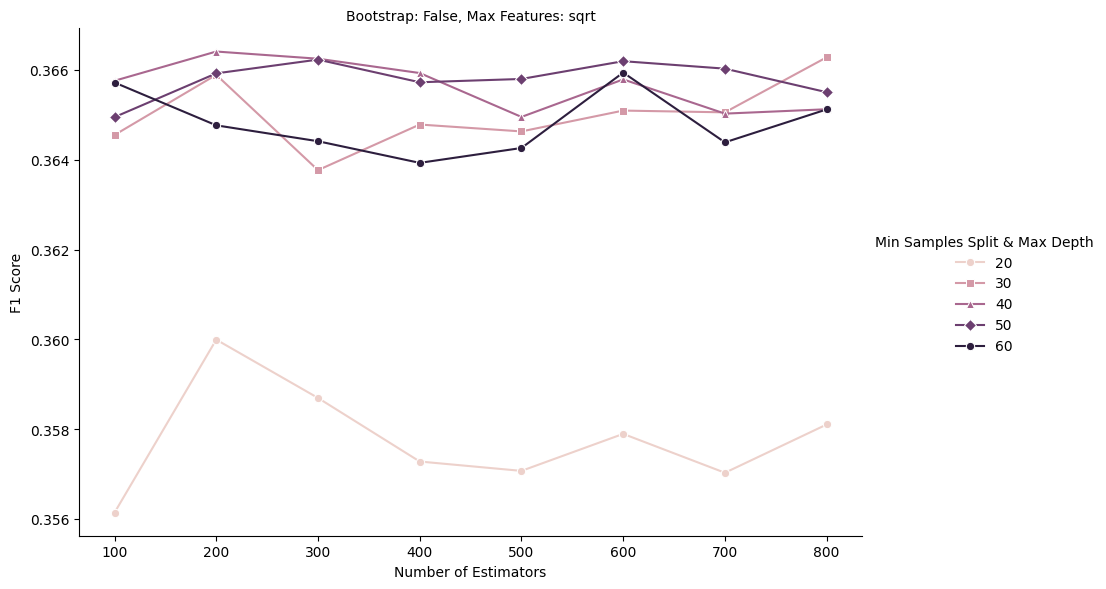

In [ ]:
# Assuming grid_search is your fitted grid search object
results = pd.DataFrame(grid_search.cv_results_)

# Rename columns for easier access
plot_results = results.rename(columns = {
    'param_classifier__bootstrap': 'bootstrap',
    'param_classifier__max_depth': 'max_depth',
    'param_classifier__max_features': 'max_feat',
    'param_classifier__min_samples_split': 'min_samples_split',
    'param_classifier__n_estimators': 'n_estimators',
    'mean_test_score': 'f1'
})

# Convert 'max_depth' to integer, ensure other necessary columns are integers
plot_results['max_depth'] = plot_results['max_depth'].astype(int)
plot_results['n_estimators'] = plot_results['n_estimators'].astype(int)
plot_results['min_samples_split'] = plot_results['min_samples_split'].astype('category')

# Ensure 'max_feat' is treated as a categorical variable for faceting
plot_results['max_feat'] = plot_results['max_feat'].astype('category')

# Ensure 'min_samples_split' is treated as a categorical variable for hue
plot_results['min_samples_split'] = plot_results['min_samples_split'].astype('category')

# Create a FacetGrid based on 'bootstrap' and 'max_feat'
g = sns.FacetGrid(plot_results,
                  col='bootstrap',          # Facet by 'bootstrap'
                  row='max_feat',           # Facet by 'max_feat'
                  height=6,                 # Set plot height
                  aspect=1.5)               # Set aspect ratio

# Map the lineplot, specifying the correct x and y values, and grouping by 'min_samples_split'
g.map(sns.lineplot,
      'n_estimators',           # X-axis: 'n_estimators' 
      'f1',                      # Y-axis: 'f1' (mean test score)
      hue=plot_results['max_depth'],   # Grouping by 'min_samples_split'
      style=plot_results['max_depth'],         # Different line styles for 'max_depth'
      markers=['o', 's', '^', 'D'],  # Use markers for different groups
      dashes=False)              # Disable dashes for lines

# Add labels, titles, and legends
g.set_axis_labels("Number of Estimators", "F1 Score")
g.set_titles("Bootstrap: {col_name}, Max Features: {row_name}")
g.add_legend(title="Min Samples Split & Max Depth")

# Show the plot
plt.show()


Below I start to put together some basic plots for the writing sample. Starting with the breakdown of conversion versus no conversion. 

0    87029
1    31398
Name: target, dtype: int64
118427


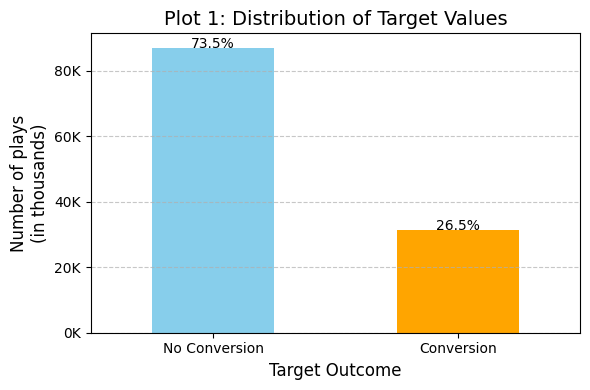

In [ ]:
# Count target values
target_values = sub_plays_filt['target'].value_counts()
print(target_values)
p = sum(target_values)
print(p)

# Calculate percentages for each target value
target_percentages = (target_values / target_values.sum()) * 100

# Update index labels for the plot
target_values.index = ['No Conversion', 'Conversion']

# Create a bar plot with updated labels
plt.figure(figsize=(6, 4))
bars = target_values.plot(kind='bar', color=['skyblue', 'orange'])

# Annotate each bar with its percentage
for bar, percentage in zip(bars.patches, target_percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X position (center of bar)
        bar.get_height() + 0.5,            # Y position (slightly above the bar)
        f"{percentage:.1f}%",             # Text (percentage)
        ha='center', fontsize=10          # Alignment and font size
    )

# Format the y-axis to show thousands with a "K" suffix
formatter = FuncFormatter(lambda x, _: f'{x/1000:.0f}K')
plt.gca().yaxis.set_major_formatter(formatter)

# Add titles and labels
plt.title('Plot 1: Distribution of Target Values', fontsize=14)
plt.xlabel('Target Outcome', fontsize=12)
plt.ylabel('Number of plays\n(in thousands)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()


First, let's consider if I guessed no conversion always as that is the most common outcome and could easily be used as a business rule assumption. 

In [15]:
# Simulate predictions (bad model predicting always negative)
y_true = sub_plays_filt['target']  # Actual target values
y_pred = np.zeros_like(y_true)  # Model always predicts '0' (negative class)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Extract values from confusion matrix
TN, FP, FN, TP = cm.ravel()  # For binary classification

# Calculate precision, recall, accuracy, F1 score, sensitivity, and specificity
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
accuracy = (TP + TN) / (TP + TN + FP + FN)
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
sensitivity = recall  # Sensitivity is the same as recall
specificity = TN / (TN + FP) if (TN + FP) != 0 else 0  # Specificity formula

# Print the calculated metrics
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")


Precision: 0.0000
Recall (Sensitivity): 0.0000
Accuracy: 0.7349
F1 Score: 0.0000
Sensitivity: 0.0000
Specificity: 1.0000


Next, fit the specific model with best parameters found above. Then, score it. 

In [ ]:
#Data cleaning pipeline
x = sub_plays_filt.loc[:, ['shotgun', 'game_half', 'last_play', 'no_huddle'
                           , 'down', 'yardline_100', 'goal_to_go', 'ydstogo'
                           , 'score_differential'
                           , 'play_seq_game', 'play_seq_drive', 'drive'
                           , 'play_seq_posteam'
                           , 'pass_seq_posteam_shift', 'rush_seq_posteam_shift', 'shot_seq_posteam_shift'
                           , 'lead_seq_posteam_shift', 'sacked_seq_posteam_shift', 'fumble_seq_posteam_shift', 'int_seq_posteam_shift' 
                           , 'posteam_timeouts_remaining', 'defteam_timeouts_remaining']]

# Identify categorical and numerical columns
categorical_cols = x.select_dtypes(include=['object']).columns
numerical_cols = x.select_dtypes(include=['number']).columns

print(f'Categorical cols: {categorical_cols}') 
print(f'Numeric cols: {numerical_cols}')

# Preprocessing for categorical and numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)

# Define the Random Forest pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42
                                          , n_estimators = 200
                                          , max_depth = 40
                                          , max_features = 'sqrt'
                                          , min_samples_split = 5
                                          , bootstrap = False))
])

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Fit the pipeline on the training data
pipeline.fit(x_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(x_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Extract values from confusion matrix
TN, FP, FN, TP = cm.ravel()  # For binary classification

# Calculate precision, recall, accuracy, F1 score, sensitivity, and specificity
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
accuracy = (TP + TN) / (TP + TN + FP + FN)
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
sensitivity = recall  # Sensitivity is the same as recall
specificity = TN / (TN + FP) if (TN + FP) != 0 else 0  # Specificity formula

# Print the classification report (precision, recall, F1 score)
print(classification_report(y_test, y_pred))

# Print the manually calculated metrics
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Categorical cols: Index(['game_half', 'last_play'], dtype='object')
Numeric cols: Index(['shotgun', 'no_huddle', 'down', 'yardline_100', 'goal_to_go', 'ydstogo',
       'score_differential', 'play_seq_game', 'play_seq_drive', 'drive',
       'play_seq_posteam', 'pass_seq_posteam_shift', 'rush_seq_posteam_shift',
       'shot_seq_posteam_shift', 'lead_seq_posteam_shift',
       'sacked_seq_posteam_shift', 'fumble_seq_posteam_shift',
       'int_seq_posteam_shift', 'posteam_timeouts_remaining',
       'defteam_timeouts_remaining'],
      dtype='object')
              precision    recall  f1-score   support

           0       0.78      0.93      0.85     17404
           1       0.58      0.27      0.37      6282

    accuracy                           0.76     23686
   macro avg       0.68      0.60      0.61     23686
weighted avg       0.73      0.76      0.72     23686

              precision    recall  f1-score   support

           0       0.78      0.93      0.85     17404
      

Next, plot some simple feature importance from this model. If you had more features it would be valuable to run a grid search, look at feature importance, and go back and forth until you feel you get a good model fit. 

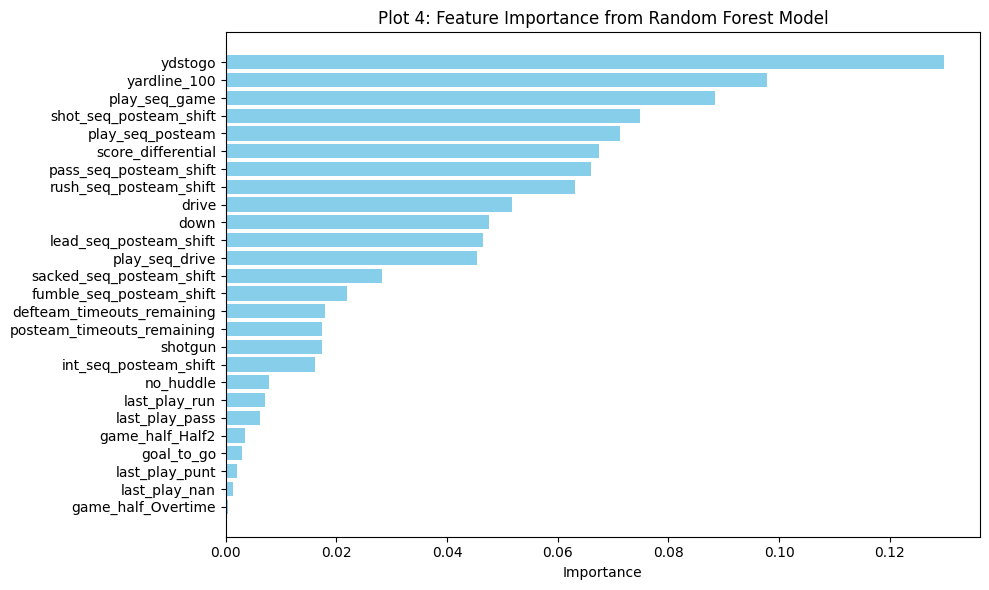

In [ ]:
# Assuming the Random Forest model is already fitted in the pipeline
# Extract feature importances from the trained Random Forest model
feature_importances = pipeline.named_steps['classifier'].feature_importances_

# Get the feature names from the preprocessor step
# For categorical features, we use one-hot encoded columns, so we get the column names
categorical_cols = x.select_dtypes(include=['object']).columns
numerical_cols = x.select_dtypes(include=['number']).columns

# The one-hot encoded column names from the preprocessor step using get_feature_names_out() method
one_hot_columns = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols)
all_feature_names = list(numerical_cols) + list(one_hot_columns)

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Plot 4: Feature Importance from Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.tight_layout()
plt.show()


Plot the confusion matrix from the best model below. 

              precision    recall  f1-score   support

           0       0.78      0.93      0.85     17404
           1       0.58      0.27      0.37      6282

    accuracy                           0.76     23686
   macro avg       0.68      0.60      0.61     23686
weighted avg       0.73      0.76      0.72     23686



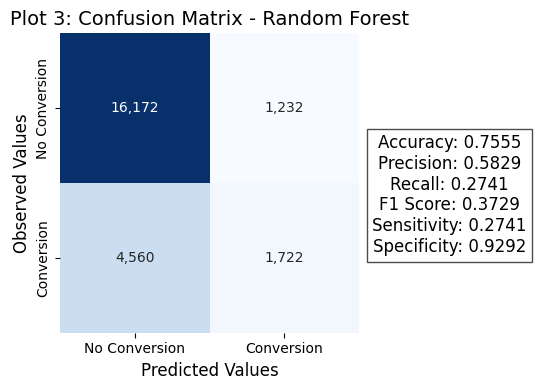

In [ ]:
# Assuming y_test and y_pred are already defined
# y_test: Observed Valuess
# y_pred: Predicted Valuess by the model

# Predict on the test data
y_pred = pipeline.predict(x_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Extract values from confusion matrix
TN, FP, FN, TP = cm.ravel()  # For binary classification

# Calculate precision, recall, accuracy, F1 score, sensitivity, and specificity
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
accuracy = (TP + TN) / (TP + TN + FP + FN)
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
sensitivity = recall  # Sensitivity is the same as recall
specificity = TN / (TN + FP) if (TN + FP) != 0 else 0  # Specificity formula

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn heatmap (without shading)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt=',.0f', cmap='Blues', xticklabels=['No Conversion', 'Conversion'], 
            yticklabels=['No Conversion', 'Conversion'], cbar=False, square=True)

# Add titles and labels
plt.title('Plot 3: Confusion Matrix - Random Forest', fontsize=14)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Observed Values', fontsize=12)

# Display evaluation metrics on the plot
metrics_text = f"Accuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}\nSensitivity: {sensitivity:.4f}\nSpecificity: {specificity:.4f}"
plt.gcf().text(.9, .5, metrics_text, fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))

# Display the plot
plt.tight_layout()
plt.show()


Plot the confusion matrix from the naive 'always no conversion' model. 

Precision: 0.0000
Recall (Sensitivity): 0.0000
Accuracy: 0.7349
F1 Score: 0.0000
Sensitivity: 0.0000
Specificity: 1.0000


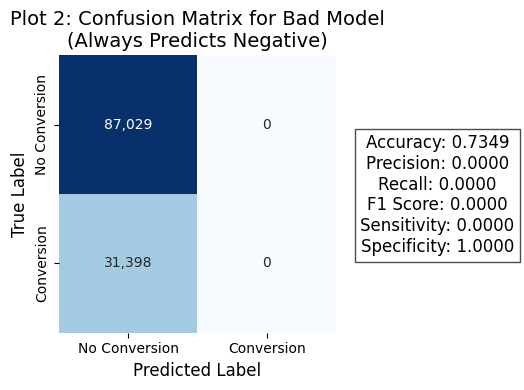

In [ ]:
# Simulate predictions (bad model predicting always negative)
y_true = sub_plays_filt['target']  # Actual target values
y_pred_bad = np.zeros_like(y_true)  # Model always predicts '0' (negative class)

# Generate confusion matrix
cm_bad = confusion_matrix(y_true, y_pred_bad)

# Extract values from confusion matrix
TN, FP, FN, TP = cm_bad.ravel()  # For binary classification

# Calculate precision, recall, accuracy, F1 score, sensitivity, and specificity
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
accuracy = (TP + TN) / (TP + TN + FP + FN)
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
sensitivity = recall  # Sensitivity is the same as recall
specificity = TN / (TN + FP) if (TN + FP) != 0 else 0  # Specificity formula

# Print the calculated metrics
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")


# Plot the confusion matrix using seaborn heatmap (without shading)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_bad, annot=True, fmt=',.0f', cmap='Blues', xticklabels=['No Conversion', 'Conversion'], 
            yticklabels=['No Conversion', 'Conversion'], cbar=False, square=True)

# Add titles and labels
plt.title('Plot 2: Confusion Matrix for Bad Model\n(Always Predicts Negative)', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)


# Display evaluation metrics
metrics_text = f"Accuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}\nSensitivity: {sensitivity:.4f}\nSpecificity: {specificity:.4f}"
plt.gcf().text(.9, .5, metrics_text, fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))

# Display the plot
plt.tight_layout()
plt.show()
